In [1]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

In [2]:
# for content cost 
def compute_content_cost(a_C, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()

    a_C_unrolled = tf.reshape(a_C, shape=[m, n_H, n_W, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, n_H, n_W, n_C])
    
    J_content = tf.reduce_sum(tf.square(a_C_unrolled - a_G_unrolled)) / (4 * n_H * n_W * n_C)
    
    return J_content

In [3]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))    
    return GA

In [4]:
# for layer style cost
def compute_layer_style_cost(a_S, a_G):
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))

    return J_style_layer

In [5]:
# weights for different layers
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [6]:
# for style cost
def compute_style_cost(model, STYLE_LAYERS):
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style_layer = compute_layer_style_cost(a_S, a_G)
        J_style += coeff * J_style_layer

    return J_style

In [7]:
# total cost
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    J = alpha * J_content + beta * J_style
    return J

In [8]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

In [9]:
def re_image(content_image, style_image):
    
    # loading the content image and normalizing it
    content_image = imageio.imread("images/" + content_image)
    re_content_image = reshape_and_normalize_image(content_image)
    
    # loading the style image and normalizing it
    style_image = imageio.imread("images/" + style_image)
    re_style_image = reshape_and_normalize_image(style_image)
    
    # generating a noise image from the content image
    generated_image = generate_noise_image(content_image)
    
    return content_image, re_content_image, style_image, re_style_image, generated_image

In [10]:
# load the model
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [11]:
def all_cost(content_image, style_image, STYLE_LAYERS):
    # assign the content image to be the input of the model.  
    sess.run(model['input'].assign(content_image))

    # the output tensor of layer conv4_2
    out = model['conv4_2']

    # hidden layer activation
    a_C = sess.run(out)
    a_G = out

    # the content cost
    J_content = compute_content_cost(a_C, a_G)

    # assign the input of the model to be the "style" image 
    sess.run(model['input'].assign(style_image))

    # compute the style cost
    J_style = compute_style_cost(model, STYLE_LAYERS)

    return J_content, J_style

In [27]:
def model_nn(sess, content, style, STYLE_LAYERS, num_iterations = 800):
    
    content_image, re_content_image, style_image, re_style_image, input_image = re_image(content, style)
    
    J_content, J_style = all_cost(re_content_image, re_style_image, STYLE_LAYERS)
    J = total_cost(J_content, J_style, alpha = 10, beta = 40)
    
    optimizer = tf.train.AdamOptimizer(2.0)

    train_step = optimizer.minimize(J)

    # initialize global variables
    sess.run(tf.global_variables_initializer())
    
    # run the noisy input image (initial generated image) through the model
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
    
        # run the session on the train_step to minimize the total cost
        sess.run(train_step)

        # compute the generated image by running the session on the current model['input']
        generated_image = sess.run(model['input'])
        
    # save last generated image
    i = save_image('output/generated_image666.jpg', generated_image)
    i = imageio.imread('output/generated_image666.jpg')
    plt.axis('off')
    plt.imshow(i)

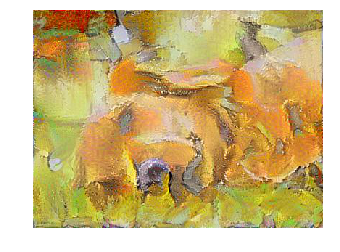

In [26]:
model_nn(sess, "dog1.jpg", "style4.jpg", STYLE_LAYERS)

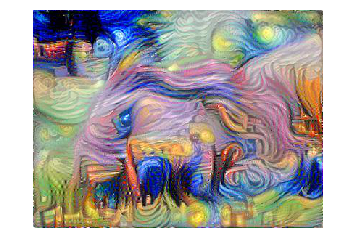

In [28]:
model_nn(sess, "dog1.jpg", "style1.jpg", STYLE_LAYERS)